In [295]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow 
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM,Dropout, BatchNormalization

## Import daily Netflix Stock prices


In [296]:
df = pd.read_csv('NFLX1.csv')
df['Date'] = pd.to_datetime(df['Date'])
print(df.head())
print()
print(f'There are {len(df)} days of Netflix stock price data') # how many days are we working with?

        Date      Open      High       Low     Close  Adj Close    Volume
0 2010-01-04  7.931428  7.961429  7.565714  7.640000   7.640000  17239600
1 2010-01-05  7.652857  7.657143  7.258572  7.358572   7.358572  23753100
2 2010-01-06  7.361429  7.672857  7.197143  7.617143   7.617143  23290400
3 2010-01-07  7.731429  7.757143  7.462857  7.485714   7.485714   9955400
4 2010-01-08  7.498571  7.742857  7.465714  7.614286   7.614286   8180900

There are 2506 days of Netflix stock price data


## Let's take the stock's Closing price & set 'Date' as index
### also don't forget to scale your data - we can inverse the scale after we fit into the model

In [297]:
df = df.set_index('Date', drop=True)
df = pd.DataFrame(df['Close'])
print('Pre-Scale\n',df.head())

Pre-Scale
                Close
Date                
2010-01-04  7.640000
2010-01-05  7.358572
2010-01-06  7.617143
2010-01-07  7.485714
2010-01-08  7.614286


In [311]:
# Scale the data - We'll be using Min-MAx Scaler with a range of 0-1
mms = MinMaxScaler()
df['Close'] = mms.fit_transform(df['Close'].values.reshape(-1,1))
df['Close'].head()

Date
2010-01-04    0.001509
2010-01-05    0.000825
2010-01-06    0.001453
2010-01-07    0.001134
2010-01-08    0.001446
Name: Close, dtype: float64

## Now, we can Split into train,validation (95%,5%)

In [316]:
threshold = round(0.05*len(df)) # we will use only 5% of the data as validation

training_ =df.iloc[:-threshold] #assign to training dataset
validation_= df.iloc[-threshold:] #assign to validation dataset

print(training_.head(),'\n',validation_.head()) 
print()
print(f'There are {len(training_)} traing data and {len(validation_)} validation data')

training_data = training_.values 
validation_data = validation_.values 

               Close
Date                
2010-01-04  0.001509
2010-01-05  0.000825
2010-01-06  0.001453
2010-01-07  0.001134
2010-01-08  0.001446 
                Close
Date                
2019-06-20  0.869499
2019-06-21  0.879209
2019-06-24  0.883651
2019-06-25  0.857580
2019-06-26  0.862193

There are 2381 traing data and 125 validation data


## Initial EDA

#### There is no consistent trend/pattern to the prices but we see it's been on the rise overall (a sudden big spike in prices near 2017) Can we still build a model to accuractely predict the stock prices? 

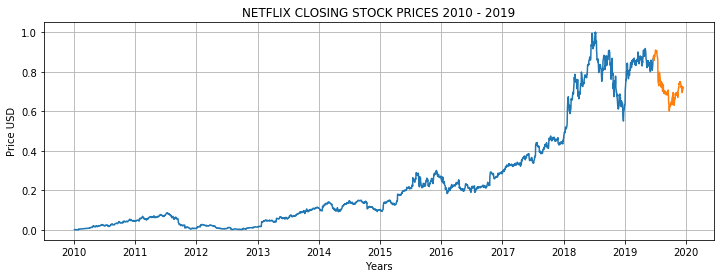

In [379]:
fig, ax = plt.subplots(figsize = (12,4))
plt.plot(training_)
plt.plot(validation_,'-')

plt.title('NETFLIX CLOSING STOCK PRICES 2010 - 2019');
plt.xlabel('Years')
plt.ylabel('Price USD')
ax.grid()

#We will try to predict Netflix stock prices for the next 125 days


## Create X_train, y_train 

In [352]:
PREV_DAYS = 30

def process(data): #take 30 values and store it as our 'X'. the 31st value will be our 'y'
    x=[]
    y=[]
    for i in range(PREV_DAYS, len(data)-1):
        x.append(data[i-PREV_DAYS:i,0])
        y.append(data[i,0])
    return x,y

train_x, train_y = process(training_data) 
train_x,train_y = np.array(train_x),np.array(train_y) # convert train_x and train_y to numpy arrays
test_x, test_y = process(validation_data)
test_x = np.array(test_x) 

In [355]:
test_y = np.array(test_y)
test_y = test_y.reshape(-1,1)
test_y = mms.inverse_transform(test_y) # we converted the test_y back to its original scaling. 
test_y[0:5]

array([[318.829987],
       [307.630005],
       [310.100006],
       [304.290009],
       [315.899994]])

## Reshape data (to fit into the LSTM model)

In [329]:
train_x[0]

array([0.0015085 , 0.00082534, 0.00145302, 0.00113398, 0.00144608,
       0.00142181, 0.00112357, 0.00167495, 0.00064502, 0.00063114,
       0.00071784, 0.00073171, 0.00071437, 0.00061034, 0.        ,
       0.00028436, 0.00063808, 0.00482373, 0.00454978, 0.0041267 ,
       0.00441106, 0.00444574, 0.00388742, 0.00406081, 0.00408162,
       0.00450816, 0.00428622, 0.0049347 , 0.00487228, 0.00545488])

In [332]:
train_x = np.reshape(train_x, (train_x.shape[0],train_x.shape[1],1))
train_x.shape

(2350, 30, 1)

## Build the LSTM Neural Network

In [406]:
model = Sequential()

model.add(LSTM(units = 25,activation='tanh',return_sequences=True,input_shape=(train_x.shape[1],1)))
model.add(Dropout(0.2))
model.add(BatchNormalization())
          
model.add(LSTM(units = 25,activation='tanh',return_sequences=True))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(LSTM(units = 25,activation='tanh',return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(25))
model.add(Dense(1))
          
model.compile(loss = 'mean_squared_error', optimizer = 'RMSProp')
                        
                        

## Train the model

In [407]:
model.fit(train_x,train_y, batch_size = 10, epochs = 25)

Epoch 1/25
2350/2350 [==============================] - 9s 4ms/sample - loss: 0.0179
Epoch 2/25
2350/2350 [==============================] - 8s 3ms/sample - loss: 0.0060
Epoch 3/25
2350/2350 [==============================] - 9s 4ms/sample - loss: 0.0042
Epoch 4/25
2350/2350 [==============================] - 8s 3ms/sample - loss: 0.0037
Epoch 5/25
2350/2350 [==============================] - 8s 3ms/sample - loss: 0.0034
Epoch 6/25
2350/2350 [==============================] - 8s 4ms/sample - loss: 0.0031
Epoch 7/25
2350/2350 [==============================] - 8s 3ms/sample - loss: 0.0029
Epoch 8/25
2350/2350 [==============================] - 8s 4ms/sample - loss: 0.0029
Epoch 9/25
2350/2350 [==============================] - 8s 3ms/sample - loss: 0.0027
Epoch 10/25
2350/2350 [==============================] - 8s 3ms/sample - loss: 0.0026
Epoch 11/25
2350/2350 [==============================] - 8s 3ms/sample - loss: 0.0022
Epoch 12/25
2350/2350 [==============================] - 8s 3ms

## Predict on our Test data

In [409]:
#First, transform test_x data into a 3D so it can be fed into our model
test_x = np.reshape(test_x, (test_x.shape[0],test_x.shape[1],1))

ypred = model.predict(test_x)
ypred_transform = mms.inverse_transform(ypred)

## Calculate the RMSE 

In [412]:
rmse = np.sqrt(np.mean(ypred_transform-test_y)**2)
rmse

# Pretty solid RMSE 

2.592268617935508

## Re-create the Chart

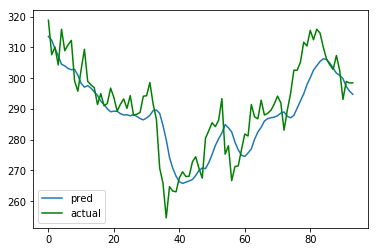

In [414]:
plt.plot(ypred_transform, label='pred')
plt.plot(test_y, 'g', label = 'actual')
plt.legend()

# the actual stock prices have a lot more daily oscillations than our predicted values. 
# Our model does a good job in general predicted the direction

In [429]:
# putting all the values back into the dataframe
df['Original'] = mms.inverse_transform(df['Close'].values.reshape(-1,1))
df_copy = df.copy()
df_copy= df_copy[-threshold+31:]
df_copy['pred'] = ypred_transform 

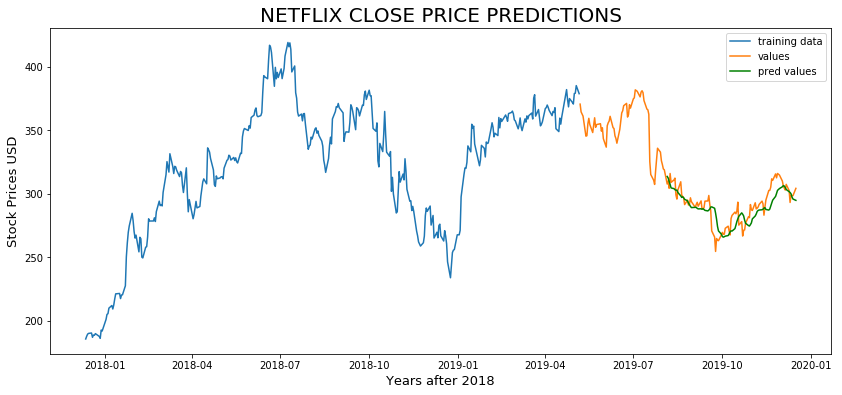

In [461]:
plt.figure(figsize=(14,6));
plt.plot(df['Original'][2000:len(train_x)], label= 'training data')
plt.plot(df['Original'][len(train_x):],'-',label = 'values')
plt.plot(df_copy['pred'], 'g', label = 'pred values')
plt.title('NETFLIX CLOSE PRICE PREDICTIONS', size= 20)
plt.xlabel('Years after 2018', size=13)
plt.ylabel('Stock Prices USD', size=13)

plt.legend();

* Notice the Green pred values do not extend to the beginning of the Orange (values) because the first 30 instances are used to predict the 31st value

* 30 days prior sequential data provides our LSTM model with enough information to accurately predict future stock prices of Netflix